In [ ]:
pip install -U tensorflow_addons

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
# May want to go to your working directory

Mounted at /content/drive/


In [ ]:
'''
https://arxiv.org/pdf/2010.11929.pdf
len(image_arr) = 15494
'''
import tensorflow as tf
# import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
import csv
import matplotlib.pyplot as plt
import glob
import pandas as pd
import re
import cv2
import matplotlib.pyplot as plt
import time

In [ ]:
'''
Prepare input images and labels (number of balls) for:
1) training
2) testing

Output:
1) image_arr
2) num_arr

col 0: time in ms
col 1:24: palm (24 values)
col 25-48: finger 0 (24 values)
49-82: other finger 1 (fixed finger, 24 values)
83-126: other finger 2 (24 values)


'''
# path_y = "/content/drive/MyDrive/ping-pongball_data_realsystem/"
# path_x = "/content/drive/MyDrive/G4_real_tact/TEST1/mult4_tact/"
# path_x0 = "/content/drive/MyDrive/G4_real_tact/TEST1/"
# # files_y = glob.glob(path_y + '/**/grasping_result.csv', recursive=True)
# files_x = glob.glob(path_x + '*.png')
# with open(path_x0 + 'file_list.txt', 'w') as fl_1:
#   for i in files_x:
#     fl_1.write("%s\n" % i)
# print('Total number of x files = ', len(files_x))

# imaget = []
# numt = []
# imaget5 = []
# numt5 = []
# counter = 0
# for i in files_x:
# # for i in files_x:
#   print(counter)
#   # print(i)
#   counter += 1
#   image = cv2.imread(i)

#   # print(image.shape)

#   # plt.figure(figsize=(4, 4))
#   # plt.imshow(image.astype("uint8"))
#   # plt.title('before')
#   # plt.axis("off")
#   # plt.show

#   image = cv2.resize(image, (512, 512))
#   # plt.figure(figsize=(4, 4))
#   # plt.imshow(image.astype("uint8"))
#   # plt.title('after')
#   # plt.axis("off")
#   # plt.show

#   names = os.path.split(i)
#   names_x = names[1]
#   name_x = names_x.split('.')
#   names_y0 = name_x[0].split('_')
#   names_y1 = re.split('(\d+)', names_y0[1])
#   open_file = path_y + names_y1[1] + '/' + 'grasping_result.csv'
#   open_file_t = path_y + names_y1[1] + '/' + 'tactile_reading.csv'
#   # print(open_file)
#   # print(open_file_t)

#   # input('Wait')

#   with open(open_file, 'r') as y1:
#     df = pd.read_csv(y1, header=None)
#     num_ball = df.iloc[0:1, 2:3].values
#     num_ball1 = int(num_ball)
#   print(num_ball1)

#   if num_ball1 == 5:
#     numt5.append([num_ball1])
#     imaget5.append(image)
#   else:
#     numt.append([num_ball1])
#     imaget.append(image)

# image_arr = np.array(imaget)
# num_arr = np.array(numt)
# image_arr5 = np.array(imaget5)
# num_arr5 = np.array(numt5)
# # print(image_arr.shape)
# # print(num_arr.shape)
# # print(num_arr)
# np.save("/content/drive/MyDrive/G4_real_tact/TEST1_mul4/image_arr", image_arr)
# np.save("/content/drive/MyDrive/G4_real_tact/TEST1_mul4/num_arr", num_arr)
# np.save("/content/drive/MyDrive/G4_real_tact/TEST1_mul4/image_arr5", image_arr5)
# np.save("/content/drive/MyDrive/G4_real_tact/TEST1_mul4/num_arr5", num_arr5)
# print(image_arr.shape)
# print(num_arr.shape)
# print(image_arr5.shape)
# print(num_arr5.shape)

'\nPrepare input images and labels (number of balls) for:\n1) training\n2) testing\n\nOutput:\n1) image_arr\n2) num_arr\n\ncol 0: time in ms\ncol 1:24: palm (24 values)\ncol 25-48: finger 0 (24 values)\n49-82: other finger 1 (fixed finger, 24 values)\n83-126: other finger 2 (24 values)\n\n\n'

In [ ]:
'''
Setting the parameters of the transfomer models
'''
img_shape = (128, 128, 3)
input_shape = (128, 128, 3)
num_classes = 7

learning_rate = 0.0005
weight_decay = 0.00005
batch_size = 4
num_epochs = 200  # You may consider using a small number to play. 2 will take less than 10 minutes to run the entire notebook.
image_size = 72
patch_size = 24
num_patches = ((image_size // (patch_size // 2)) - 1) ** 2
projection_dim = 128
depth = 64
num_heads = 4
transformer_units = [projection_dim * 2, projection_dim,]
transformer_layers = 16
mlp_head_units = [4096, 2048]

In [ ]:
'''
Load image_arr and num_arr to save time
Separate into training and testing sets
'''
image_arr_train = np.load("/content/drive/MyDrive/Colab Notebooks/data/data_numpy_arrays/image_arr_train.npy")
num_arr_train = np.load("/content/drive/MyDrive/Colab Notebooks/data/data_numpy_arrays/num_arr_train.npy")
image_arr_test = np.load("/content/drive/MyDrive/Colab Notebooks/data/data_numpy_arrays/image_arr_test.npy")
num_arr_test = np.load("/content/drive/MyDrive/Colab Notebooks/data/data_numpy_arrays/num_arr_test.npy")


In [ ]:
x_test = image_arr_test
y_test = num_arr_test

x_train = image_arr_train
y_train = num_arr_train

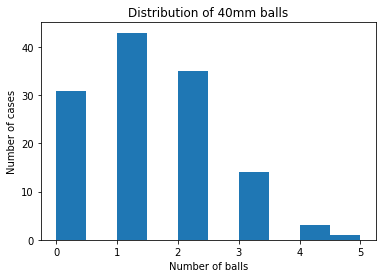

In [ ]:
n, bins, patches = plt.hist(y_test)
plt.title('Distribution of 40mm balls')
plt.xlabel("Number of balls")
plt.ylabel("Number of cases")
plt.show()

In [ ]:
'''
keras data augmentation
'''
data_augmentation = keras.Sequential(
    [
     layers.Normalization(),
     layers.Resizing(image_size, image_size),
     layers.RandomFlip("horizontal"),
     layers.RandomRotation(factor=0.02),
     layers.RandomZoom(
         height_factor=0.2, width_factor=0.2
     ),
    ],
    name='data_augmentation',
)

data_augmentation.layers[0].adapt(x_train)

In [ ]:
'''
Multi-layer perceptron (mlp)
'''
def mlp(x, hidden_units, dropout_rate):
  for units in hidden_units:
    x = layers.Dense(units, activation=tf.nn.gelu)(x)
    x = layers.Dropout(dropout_rate)(x)
  return x

In [ ]:
'''
class Patches(layers.Layer)
- for making patches
Output:
- patches
'''
class Patches(layers.Layer):
  def __init__(self, patch_size):
    super(Patches, self).__init__()
    self.patch_size = patch_size
    print('patch_size', patch_size)

  def call(self, input_img):
    sample_size = tf.shape(input_img)[0]
    print('tf.shape(input_img)', tf.shape(input_img))
    patches = tf.image.extract_patches(
        images=input_img,
        sizes=[1, self.patch_size, self.patch_size, 1],
        strides=[1, self.patch_size/2, self.patch_size/2, 1],
        rates=[1, 1, 1, 1],
        padding='VALID',
    )
    patch_dims = patches.shape[-1]
    # print('patch_dims', patch_dims)
    # print('patches.shape', patches.shape)
    patches = tf.reshape(patches, [sample_size, -1, patch_dims])
    # print('old patches.shape', patches.shape)

    return patches


patch_size 24
tf.shape(input_img) tf.Tensor([ 1 72 72  3], shape=(4,), dtype=int32)
Image size: 72 X 72
Patch size: 24 X 24
Patches per image: 25
Elements per patch: 1728


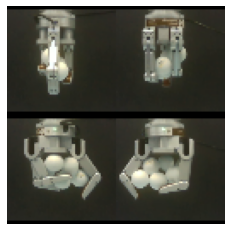

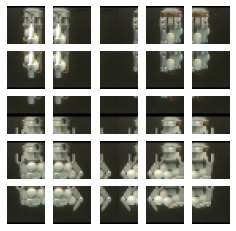

In [ ]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
'''
class PatchEncorder
- for:
1) patch projection
2) position embedding layer
output = new_patch
'''
class PatchEncoder(layers.Layer):
  def __init__(self, num_patches, projection_dim):
    super(PatchEncoder, self).__init__()
    self.num_patches = num_patches
    self.projection = layers.Dense(units = projection_dim)
    self.position_embedding = layers.Embedding(
        input_dim=num_patches, output_dim=projection_dim
    )

  def call(self, patch):
    # print('num_patches', self.num_patches)
    positions = tf.range(start=0, limit=self.num_patches, delta=1)
    # print(len(positions))
    # print(len(self.projection(patch)))
    # print(len(self.position_embedding(positions)))
    encoded = self.projection(patch) + self.position_embedding(positions)
    return encoded

In [ ]:
'''
function for the transformer
Output: model
'''
def vit_classifier_mod():
  inputs = layers.Input(shape=input_shape)
  print('inputs', inputs.shape)
  augmented = data_augmentation(inputs)
  print('augmented', augmented.shape)
  patches = Patches(patch_size)(augmented)
  print('patches', patches.shape)
  encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
  print('encoded_patches', encoded_patches.shape)

  for i in range(transformer_layers):
    x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    print('x1', x1.shape)
    attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
    x2 = layers.Add()([attention_output, encoded_patches])
    print('x2', x2.shape)
    x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
    x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
    print('x3', x3.shape)
    encoded_patches = layers.Add()([x3, x2])
    print('encoded_patches', encoded_patches.shape)

  classifier_out = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
  classifier_out = layers.Flatten()(classifier_out)
  classifier_out = layers.Dropout(0.5)(classifier_out)

  features = mlp(classifier_out, hidden_units=mlp_head_units, dropout_rate=0.5)
  output_class = layers.Dense(num_classes, activation = tf.nn.softmax)(features)

  model = keras.Model(inputs=inputs, outputs=output_class)
  return model

In [ ]:
# asymmetric loss function
# +ve to punish overestimation, increase by x% and vice versa

def asymmetric_loss(alpha):
  def loss(y_true, y_pred):

    df3 = tf.argmax(y_pred, 1, name=None)
    # print('df3', df3)
    df4 = tf.argmax(y_true, 1, name=None)
    # print('df4', df4)
    # y_true_reshaped = tf.reshape(y_true,[y_true.shape[0]])
    y_true_reshaped = tf.gather(y_true, df4, axis=1, batch_dims=1)
    # print('y_true_reshaped', y_true_reshaped)
    delta = int(y_true_reshaped) - int(df3)

    select1 = tf.gather(y_pred, y_true_reshaped, axis=1, batch_dims=1)  + 1e-20
    
    loss0a = -1 * (tf.math.log(select1))
    loss0b = float(tf.sign(delta)) * (tf.math.log(select1)) * 0.6
    loss0 = loss0a - loss0b

    return loss0
  return loss

In [ ]:
'''
Compile, train, test
'''

alpha = -0.5  # acutally not used here

def main(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=asymmetric_loss(alpha=alpha),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy"),],
    )

    checkpoint_filepath = "/content/drive/MyDrive/Balanced/Real_ball/mult4_no_t/asym/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    return history

vit_classifier = vit_classifier_mod()
history = main(vit_classifier)

inputs (None, 128, 128, 3)
augmented (None, 72, 72, 3)
patch_size 24
tf.shape(input_img) Tensor("patches_1/Shape_1:0", shape=(4,), dtype=int32)
patches (None, None, 1728)
encoded_patches (None, 25, 128)
x1 (None, 25, 128)
x2 (None, 25, 128)
x3 (None, 25, 128)
encoded_patches (None, 25, 128)
x1 (None, 25, 128)
x2 (None, 25, 128)
x3 (None, 25, 128)
encoded_patches (None, 25, 128)
x1 (None, 25, 128)
x2 (None, 25, 128)
x3 (None, 25, 128)
encoded_patches (None, 25, 128)
x1 (None, 25, 128)
x2 (None, 25, 128)
x3 (None, 25, 128)
encoded_patches (None, 25, 128)
x1 (None, 25, 128)
x2 (None, 25, 128)
x3 (None, 25, 128)
encoded_patches (None, 25, 128)
x1 (None, 25, 128)
x2 (None, 25, 128)
x3 (None, 25, 128)
encoded_patches (None, 25, 128)
x1 (None, 25, 128)
x2 (None, 25, 128)
x3 (None, 25, 128)
encoded_patches (None, 25, 128)
x1 (None, 25, 128)
x2 (None, 25, 128)
x3 (None, 25, 128)
encoded_patches (None, 25, 128)
x1 (None, 25, 128)
x2 (None, 25, 128)
x3 (None, 25, 128)
encoded_patches (None, 25, 1

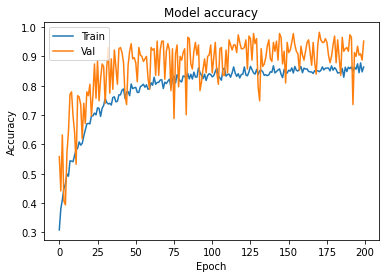

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
images_dir = '/content/drive/MyDrive/Balanced/Real_ball/mult4_no_t/asym/'
plt.savefig(f"{images_dir}/acc.jpg")
plt.show()

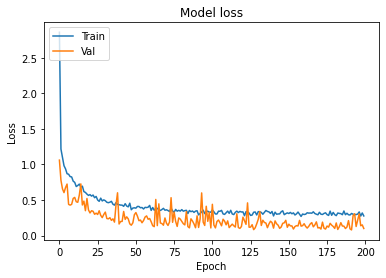

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig(f"{images_dir}/loss.jpg")
plt.show()

In [ ]:
_, accuracy = vit_classifier.evaluate(x_test, y_test)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
# print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")
start = time.time()
predictions = vit_classifier.predict(x_test)
end = time.time()
print('prediction time = ', end - start)

with open('/content/drive/MyDrive/Colab Notebooks/data/data_numpy_arrays/image_arr_train.csv', 'w') as w1:
  wfile = csv.writer(w1)
  wfile.writerows(predictions)
print("Predicitons: ", predictions)
with open("/content/drive/MyDrive/Colab Notebooks/data/data_numpy_arrays/prediction.npy", 'wb') as f:
  np.save(f, predictions)

4/4 [==============================] - 0s 92ms/step - loss: 0.1570 - accuracy: 0.8976
Test accuracy: 89.76%
prediction time =  0.40564751625061035
Predicitons:  [[9.99988794e-01 1.09240154e-05 2.30080066e-09 7.71884466e-12
  7.91937715e-09 2.34147009e-07 6.40657666e-11]
 [4.01954204e-01 5.97774625e-01 7.51723273e-05 9.20809271e-07
  3.91897411e-05 1.55791437e-04 2.91853848e-08]
 [9.90969360e-01 8.96566547e-03 6.03124590e-06 1.66667846e-07
  1.22080164e-05 4.65554622e-05 2.34756747e-08]
 [9.92045879e-01 7.91526306e-03 2.01015678e-06 4.63798813e-08
  6.00703061e-06 3.08697599e-05 1.00628137e-08]
 [9.93528664e-01 6.44057710e-03 1.76990818e-06 3.41450033e-08
  4.50131165e-06 2.45270076e-05 7.95993227e-09]
 [1.00000000e+00 4.20871844e-12 7.25294269e-11 3.17621422e-36
  1.52228548e-28 7.17325363e-16 4.47006391e-14]
 [1.00000000e+00 2.67840004e-12 1.21779995e-12 3.13305291e-26
  2.33161975e-19 4.00684390e-12 3.28259250e-14]
 [9.87037063e-01 1.28437988e-02 1.66466252e-05 4.36640363e-07
  1.997

In [ ]:
'''
Compile, train, test
'''
alpha = -0.5  # not used

def main(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=asymmetric_loss(alpha=alpha),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/content/drive/MyDrive/Balanced/Real_ball/mult4_no_t/asym/checkpoint"

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    start = time.time()
    predictions = model.predict(x_test)
    end = time.time()
    print('prediction time = ', end - start)
    with open('/content/drive/MyDrive/Balanced/Real_ball/mult4_no_t/asym/predictions.csv', 'w') as w1:
      wfile = csv.writer(w1)
      wfile.writerows(predictions)
    print("Predicitons: ", predictions)
    np.save("/content/drive/MyDrive/Balanced/Real_ball/mult4_no_t/asym/predictions", predictions)

vit_classifier = vit_classifier_mod()
history = main(vit_classifier)

inputs (None, 128, 128, 3)
augmented (None, 72, 72, 3)
patch_size 24
tf.shape(input_img) Tensor("patches_2/Shape_1:0", shape=(4,), dtype=int32)
patches (None, None, 1728)
encoded_patches (None, 25, 128)
x1 (None, 25, 128)
x2 (None, 25, 128)
x3 (None, 25, 128)
encoded_patches (None, 25, 128)
x1 (None, 25, 128)
x2 (None, 25, 128)
x3 (None, 25, 128)
encoded_patches (None, 25, 128)
x1 (None, 25, 128)
x2 (None, 25, 128)
x3 (None, 25, 128)
encoded_patches (None, 25, 128)
x1 (None, 25, 128)
x2 (None, 25, 128)
x3 (None, 25, 128)
encoded_patches (None, 25, 128)
x1 (None, 25, 128)
x2 (None, 25, 128)
x3 (None, 25, 128)
encoded_patches (None, 25, 128)
x1 (None, 25, 128)
x2 (None, 25, 128)
x3 (None, 25, 128)
encoded_patches (None, 25, 128)
x1 (None, 25, 128)
x2 (None, 25, 128)
x3 (None, 25, 128)
encoded_patches (None, 25, 128)
x1 (None, 25, 128)
x2 (None, 25, 128)
x3 (None, 25, 128)
encoded_patches (None, 25, 128)
x1 (None, 25, 128)
x2 (None, 25, 128)
x3 (None, 25, 128)
encoded_patches (None, 25, 1

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch


# from functools import partial

# save np.load
# np_load_old = partial(np.load)

# modify the default parameters of np.load
# np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)


predictions = np.load("/content/drive/MyDrive/Colab Notebooks/adv robot/confusion matrix/predicts.npy",allow_pickle=True)
y_test=np.load("/content/drive/MyDrive/Colab Notebooks/adv robot/confusion matrix/gt.npy")
df1 = predictions
df1 = df1.argmax(axis=1)
print('df1 max', max(df1))

cm = confusion_matrix(y_test, df1)

ax = plt.subplot()
sns.color_palette("YlOrBr", as_cmap=True)
sns.heatmap(cm, cmap="Reds", annot=True, fmt='g', ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix (Total = %s)' % len(y_test))
ax.xaxis.set_ticklabels(['0', '1', '2', '3', '4', '5'])
ax.yaxis.set_ticklabels(['0', '1', '2', '3', '4', '5'])

plt.show()

RuntimeError: ignored

In [ ]:
for m in range(cm.shape[0]):
  print('%s-ball: %s%%' %(m, int(round(100*cm[m,m]/np.sum(cm[m,:]), 0))))
print('Overall: %s%%' %(int(round(100 * np.trace(cm)/np.sum(cm[:,:]), 0))))


0-ball: 90%
1-ball: 95%
2-ball: 86%
3-ball: 86%
4-ball: 100%
5-ball: 0%
Overall: 90%
